# 1.Loading the data

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
download = drive.CreateFile({'id': '1K1rpp1cP61oOjKc9CIx-0v4z2SdyOpyi'})
download.GetContentFile('final.sqlite')


In [ ]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

## 3.1 Spliting CleanedText and Score into train and test

In [0]:
final=final.sort_values(by=['Time'],ascending=False)
finalDataPoints=final.head(100000)
x=finalDataPoints["CleanedText"]
y=finalDataPoints["Score"]

x_tr,x_test,y_tr,y_test=train_test_split(x, y, test_size=0.2,shuffle=False)

In [0]:
print(x_tr.shape,x_test.shape,y_tr.shape,y_test.shape)

(80000,) (20000,) (80000,) (20000,)


# 4.Bag of Words (BoW)

## 4.1 Unigram

In [0]:
#BOW for unigram
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)


from sklearn.preprocessing import StandardScaler
x_tr_uni = StandardScaler(with_mean = False).fit_transform(x_tr_uni)
x_test_uni = StandardScaler(with_mean = False).fit_transform(x_test_uni)

## 4.1.1 Grid search

### 4.1.1.1 Finding the optimal C using gridsearch

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 23.8min finished


Best HyperParameter:  {'C': 0.01}
0.8821614262331361


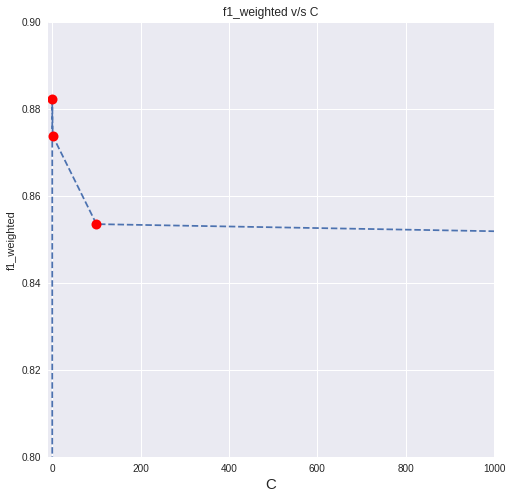

In [0]:
LR = LogisticRegression(penalty='l1')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.1.1.2 finding the accuracy,F1-score in Test data using optimal C

Accuracy on test set: 90.940%
Precision on test set: 0.879
Recall on test set: 0.791
F1-Score on test set: 0.825


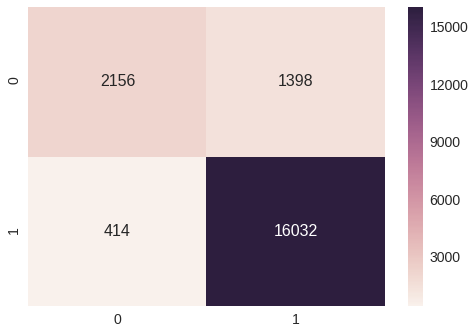

In [0]:
LR= LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_uni,y_tr)
y_pred =LR.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.1.2 RandomSearchCV

### 4.1.2.1 Finding the optimal C using RandomSearchCv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.3s finished


Best HyperParameter:  {'C': 0.05971548761688816}
0.90190625


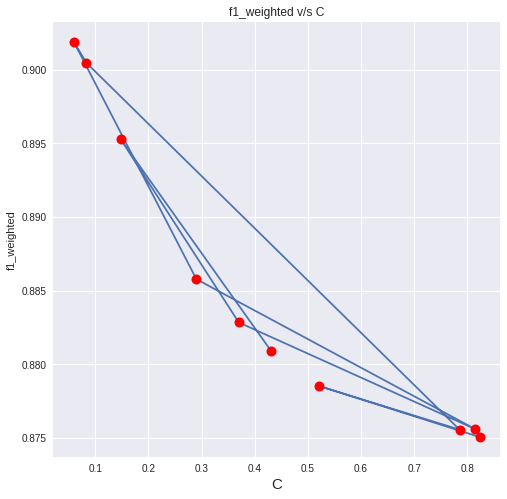

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
LR = LogisticRegression(penalty='l1')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_micro',n_jobs=-1)
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.1.2.2 finding the accuracy,F1-score in Test data using optimal C

Accuracy on test set: 91.200%
Precision on test set: 0.864
Recall on test set: 0.822
F1-Score on test set: 0.840


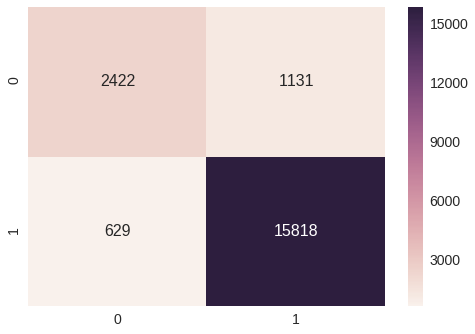

In [0]:
LR= LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_uni,y_tr)
y_pred =LR.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.1.3 Top Feature

### Adding small noise in train data

In [0]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001,size=x_tr_uni.shape)
x_tr_uni_Epsilon= x_tr_uni + epsilon

### Find with weight vector using train without noise

In [0]:
LR= LogisticRegression(penalty='l1',C=1000)
LR.fit(x_tr_uni,y_tr)
w_1=LR.coef_

### Find with weight vector using train with noise

In [0]:
LR= LogisticRegression(penalty='l1',C=1000)
LR.fit(x_tr_uni_Epsilon,y_tr)
w_2=LR.coef_

In [0]:
w=(w_2-w_1)
w=w/w_1

In [0]:
w=np.nan_to_num(w)

In [0]:
w=w*100
#theshold value is 30%
w=w[np.where( w < 30 )]

array([[-0.01507723,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.        ]])

#### dividing W list into p_pos(+ve feature) and n_neg (-ve features)

In [0]:
w_Pos=w[np.where( w >= 0 )]
w_Neg=w[np.where( w < 0 )]

In [0]:
features = (-w_Pos).argsort()
print(np.take(bow.get_feature_names(), features[:10]))

['merrick' 'rancher' 'ran' 'duck' 'minut' 'miracl' 'mixtur' 'quota' 'quit'
 'dislik']


In [0]:
features = (-w_Neg).argsort()
print(np.take(bow.get_feature_names(), features[:10]))

['asia' 'candida' 'cookbook' 'brush' 'bargain' 'consequ' 'crush' 'darn'
 'cheap' 'abl']


## 4.2 Bi-Grams


In [0]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr_bi = bi_gram.fit_transform(x_tr)
x_test_bi = bi_gram.transform(x_test)

x_tr_bi = StandardScaler(with_mean = False).fit_transform(x_tr_bi)
x_test_bi = StandardScaler(with_mean = False).fit_transform(x_test_bi)

## 4.2.1.1 GridSeach

### 4.2.1.1 Finding the optimal C using gridsearchcv

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.2min finished


Best HyperParameter:  {'C': 0.01}
0.8768442132492991


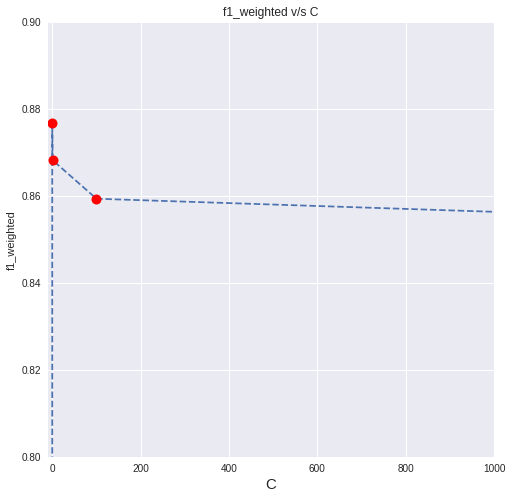

In [0]:
LR = LogisticRegression(penalty='l1')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1]
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.2.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 90.650%
Precision on test set: 0.892
Recall on test set: 0.768
F1-Score on test set: 0.812


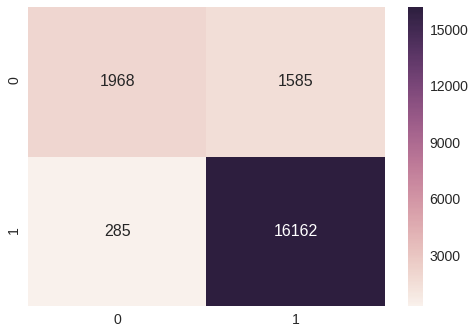

In [0]:
LR= LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_bi,y_tr)
y_pred =LR.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.2.1.2 Randomseachcv

### 4.2.1.1 Finding the optimal alpha using RandomSearchCv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.7min finished


Best HyperParameter:  {'C': 0.06167304914132732}
0.8707913462469032


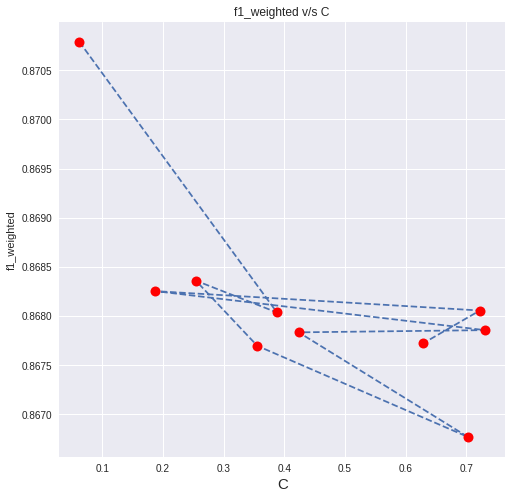

In [0]:
LR = LogisticRegression(penalty='l1')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_



x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.2.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 90.380%
Precision on test set: 0.883
Recall on test set: 0.765
F1-Score on test set: 0.807


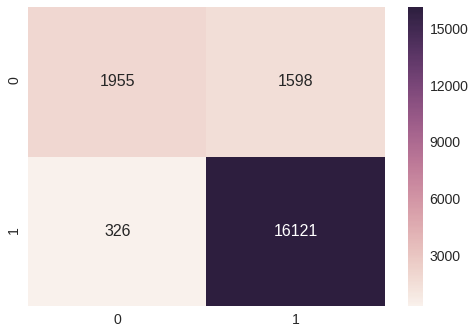

In [0]:
LR= LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_bi,y_tr)
y_pred =LR.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.2.3 Top Features

### Adding small noise in train data

In [0]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001,size=x_tr_bi.shape)
x_tr_bi_Epsilon= x_tr_bi + epsilon

### Find with weight vector using train without noise

In [0]:
LR= LogisticRegression(penalty='l1',C=1000)
LR.fit(x_tr_bi,y_tr)
w_1=LR.coef_

### Find with weight vector using train with noise

In [0]:
LR= LogisticRegression(penalty='l1',C=1000)
LR.fit(x_tr_bi_Epsilon,y_tr)
w_2=LR.coef_

In [ ]:
w=(w_2-w_1)
w=w/w_1

In [0]:
w=np.nan_to_num(w)

In [0]:
w=w*100
w=w[np.where( w < 30 )]

array([[ 1.96696676, -0.79636213, -1.        , ..., -1.        ,
         0.        ,  0.08194953]])

#### dividing W list into p_pos(+ve feature) and n_neg (-ve features)

In [0]:
w_Pos_bi=w[np.where( w > 0 )]
w_Neg_bi=w[np.where( w < 0 )]

In [0]:
features = (-w_Pos_bi).argsort()
print(np.take(bi_gram.get_feature_names(), features[:10]))

['bottl finger' 'blood' 'coat salad' 'blood sugar' 'coat bottom'
 'blossom milder' 'coat' 'blue buffalo' 'blue moon' 'blue runner']


In [0]:
features = (-w_Neg_bi).argsort()
print(np.take(bi_gram.get_feature_names(), features[:10]))

['base look' 'comfort' 'also love' 'around kitchen' 'broken pod'
 'cost throw' 'delici sweet' 'altern along' 'anyway hope' 'comment happi']


# 5 TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)
x_tr_tfidf = StandardScaler(with_mean = False).fit_transform(x_tr_tfidf)
x_test_tfidf = StandardScaler(with_mean = False).fit_transform(x_test_tfidf)

# 5.1 GridSearch

## 5.1.1 Finding the optimal C using GridsearchCv

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.1min finished


Best HyperParameter:  {'C': 0.01}
0.8836329910519565


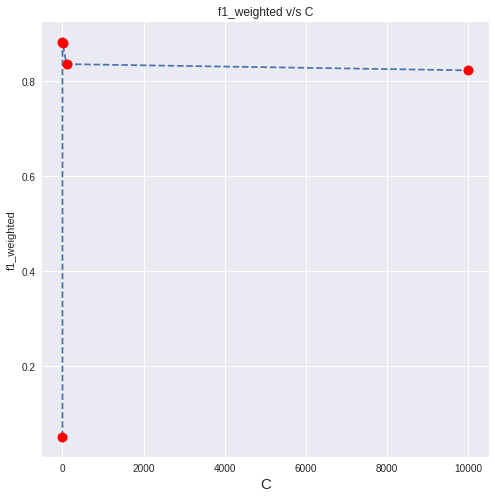

In [0]:
LR = LogisticRegression(penalty='l1')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_



x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1]
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 5.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 91.260%
Precision on test set: 0.902
Recall on test set: 0.783
F1-Score on test set: 0.826


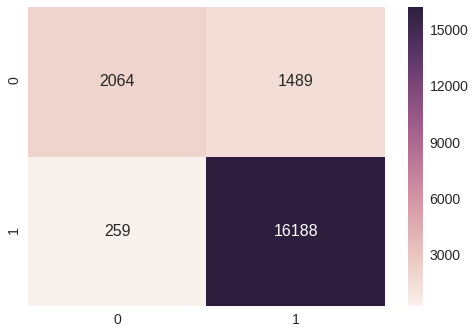

In [0]:
LR= LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_tfidf,y_tr)
y_pred =LR.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 5.2 RandomSearchCv

## 5.2.1 Finding the optimal C using RandomSearchCv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


Best HyperParameter:  {'C': 0.04124178703030934}
0.8804320582072727


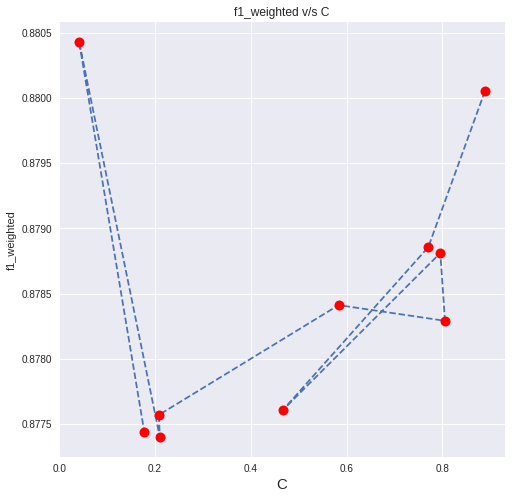

In [0]:
LR = LogisticRegression(penalty='l1')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_



x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 5.2.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 91.035%
Precision on test set: 0.893
Recall on test set: 0.782
F1-Score on test set: 0.823


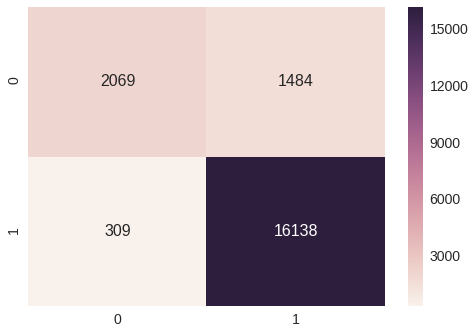

In [0]:
LR= LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_tfidf,y_tr)
y_pred =LR.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Adding small noise in train data

In [0]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001,size=x_tr_tfidf.shape)
x_tr_tfidf_Epsilon= x_tr_tfidf + epsilon

### Find with weight vector using train without noise

In [0]:
LR= LogisticRegression(penalty='l1',C=1000)
LR.fit(x_tr_tfidf,y_tr)
w_1=LR.coef_

### Find with weight vector using train with noise

In [0]:
LR= LogisticRegression(penalty='l1',C=1000)
LR.fit(x_tr_tfidf_Epsilon,y_tr)
w_2=LR.coef_

In [0]:
w=(w_2-w_1)
w=w/w_1


In [0]:
w=np.nan_to_num(w)

In [0]:
w=w*100
w=w[np.where( w < 30 )]

array([[ 2.35053779e+001,  1.51501257e+001,  0.00000000e+000, ...,
        -1.79769313e+308,  0.00000000e+000,  0.00000000e+000]])

#### dividing W list into p_pos(+ve feature) and n_neg (-ve features)

In [0]:
w_Pos_tfidf=w[np.where( w > 0 )]
w_Neg_tfidf=w[np.where( w < 0 )]

In [0]:
features = (-w_Pos_tfidf).argsort()
print(np.take(tf_idf_vect.get_feature_names(), features[:10]))

['benefit digest' 'bold' 'clear scalp' 'bold flavor' 'bold without' 'bomb'
 'bomb cant' 'bone area' 'clear product' 'clear one']


In [0]:
features = (-w_Neg_tfidf).argsort()
print(np.take(tf_idf_vect.get_feature_names(), features[:10]))

['alon food' 'beat eas' 'come chicken' 'bonus delici' 'come could'
 'buy trhough' 'amazon never' 'cayenn' 'buy fewer' 'brew quick']


# 6 Word2Vec

In [0]:
i=0
list_of_sent=[]
for sent in x_tr:
    list_of_sent.append(sent.split())
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7482
sample words  ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'great', 'product', 'good', 'price', 'definit', 'order', 'use', 'bottl', 'empti', 'expect', 'box', 'full', 'fortun', 'cooki', 'like', 'one', 'nonetheless', 'got', 'small', 'tast', 'weird', 'okay', 'best', 'ever', 'review', 'amazon', 'check', 'label', 'contain', 'sure', 'enough', 'propylen', 'glycol', 'top', 'ingredi', 'ive', 'done']


# 7.Avg W2V

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

32000
50


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

8000
50


In [0]:
x_test_av1=sent_vectors_test
x_tr_av1=sent_vectors

x_test_av1 = StandardScaler(with_mean = False).fit_transform(x_test_av1)
x_tr_av1 = StandardScaler(with_mean = False).fit_transform(x_tr_av1)

# 7.1 Gridsearch

## 7.1.1 Finding the optimal C using GridSearchcv 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.6min finished


Best HyperParameter:  {'C': 1}
0.8702509230254457


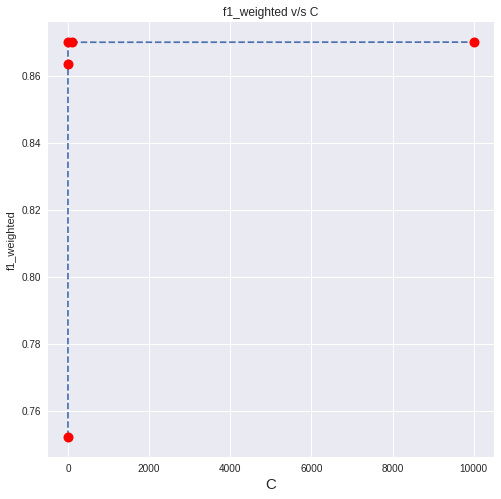

In [0]:
LR = LogisticRegression(penalty='l1')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 7.1.2 finding the accuracy in Test data using optimal C


Recall on test set: 0.748
F1-Score on test set: 0.780


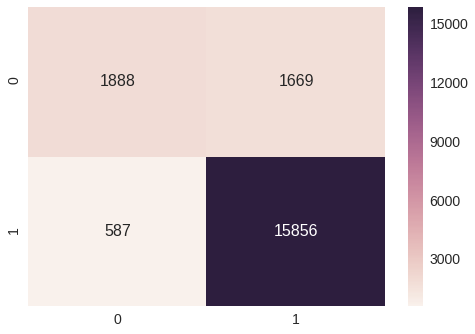

In [0]:
LR= LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_av1,y_tr)
y_pred =LR.predict(x_test_av1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 7.2 RandomSearchCv

## 7.2.1 Finding the optimal C using RandomSearchCv

In [0]:
from scipy.stats import uniform
LR = LogisticRegression(penalty='l1')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_



x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.4min finished


Best HyperParameter:  {'C': 0.369105965905427}
0.8798125


## 7.2.2 Finding the optimal C using GridSearch

Accuracy on test set: 88.565%
Precision on test set: 0.829
Recall on test set: 0.746
F1-Score on test set: 0.777


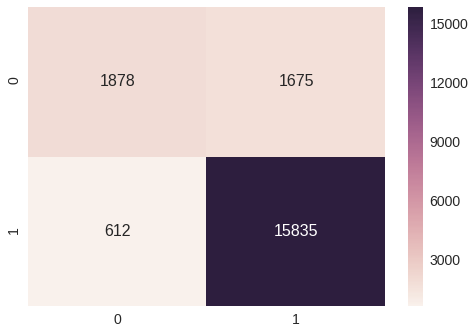

In [0]:
LR= LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_av1,y_tr)
y_pred =LR.predict(x_test_av1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 8. TFIDF-W2V

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_tr)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 80000/80000 [02:08<00:00, 622.37it/s]


In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:33<00:00, 588.58it/s]


In [0]:
x_test_tdfw2v=tfidf_sent_vectors_test
x_tr_tdfw2v=tfidf_sent_vectors
x_test_tdfw2v = StandardScaler(with_mean = False).fit_transform(x_test_tdfw2v)
x_tr_tdfw2v = StandardScaler(with_mean = False).fit_transform(x_tr_tdfw2v)

## 8.1 GridSearch

### 8.1.1 Finding the optimal C using GridSearch

In [0]:
LR = LogisticRegression(penalty='l2')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tdfw2v,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1]
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.4min finished


Best HyperParameter:  {'C': 10000}
0.8594077660890298


### 8.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 86.775%
Precision on test set: 0.774
Recall on test set: 0.673
F1-Score on test set: 0.705


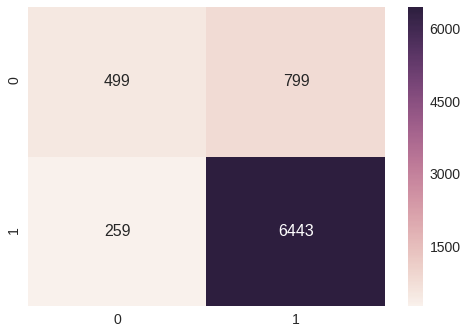

In [0]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_tdfw2v,y_tr)
y_pred =LR.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 8.2 RandomSearchcv

### 8.2.1 Finding the optimal C using RandomSearch

In [0]:
LR = LogisticRegression(penalty='l2')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_tdfw2v,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['C']) 
    y.append(a[1]
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished


Best HyperParameter:  {'C': 0.04785560628583929}
0.86578125


## 8.1.2 finding the accuracy in Test data using optimal C

Accuracy on test set: 86.810%
Precision on test set: 0.803
Recall on test set: 0.693
F1-Score on test set: 0.728


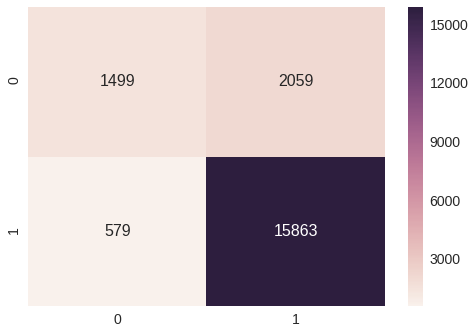

In [0]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_tdfw2v,y_tr)
y_pred =LR.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# GridSearch Conclusion



| Model | hyper parameter   |F1score test|accuracy Test
|------|------|------|------|
|  unigram  | 1| 0.793|87.740%|
| Bi-gram | 1|0.812| 90.650%|
|  Tf-IDF | 1| 0.826| 91.260%|
| Av-Word2Vec |100|0.777|88.565%|
|  Tf-IDF Word2vec |0.0001|0.607| 84.705%|


# RandomSearch Conclusion



| Model | hyper parameter   |F1score test|accuracy Test
|------|------|------|------|
|  unigram  |0.0386|0.840|91.200%|
| Bi-gram | 0.751|0.807|90.380%|
|  Tf-IDF | 0.0800|0.823|91.035%|
| Av-Word2Vec | 0.41|0.777|88.565%|
|  Tf-IDF Word2vec |0.55|0.728|86.810%|
